# <a id='toc1_'></a>[Data Modeling](#toc0_)

Name  
Topic  
email  
June 4th, 2023  


**Table of contents**<a id='toc0_'></a>    
- [Data Modeling](#toc1_)    
- [Logistic Regression: Preparation, Initiation, and Evaluation](#toc2_)    
  - [Logistic Regression: Hypothesis Formation](#toc2_1_)    
  - [Logistic Regression: Assumptions](#toc2_2_)    
  - [Logistic Regression: Initiation](#toc2_3_)    
  - [5.4. Logistic Regression Model 1: Iteration](#toc2_4_)    
  - [5.5. Logistic Regression Model 1: Evaluation](#toc2_5_)    
  - [Logistic Regression Model 1: Efficiency Evaluation](#toc2_6_)    
  - [Logistic Regression: Assessing Residuals](#toc2_7_)    
- [Key Findings](#toc3_)    
- [Recommendations](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [18]:
from my_code import *


In [19]:
# initialize styling params
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
plt.style.use('fivethirtyeight')

sns.set_style("whitegrid")
sns.set_palette("viridis")
sns.set_context("notebook")

pd.set_option("display.max_columns", 50)
pd.set_option('display.max_colwidth', 1000)
pd.plotting.register_matplotlib_converters()
os.environ["PYTHONHASHSEED"] = "123"

# import warnings
# warnings.filterwarnings('ignore')

In [20]:
from sklearn.datasets import load_iris

# Load iris dataset
iris = load_iris()

# Create a DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target


iris_df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0



# <a id='toc2_'></a>[Logistic Regression: Preparation, Initiation, and Evaluation](#toc0_)

In this section, we will apply some machine learning models on the data.


## <a id='toc2_1_'></a>[Logistic Regression: Hypothesis Formation](#toc0_)



To properly perform a Logistic Regression, we need to first declare what hypothesis we are testing. In this case, we are testing the hypothesis that the independent variables (features) are predictive of the dependent variable (rating) stated as:

<div style="background-color: #e0e0e0; padding: 10px; border-radius: 10px; border: 1px solid #333;">

**Hypothesis:**
- $H_0: β_i = 0$ (The independent variable has no effect on the target variable)
- $H_a: β_i ≠ 0$ (The independent variable has a significant effect on the target variable)

</div>


I will be using a threshold of $\alpha = 0.05$ to determine statistical significance.

## <a id='toc2_2_'></a>[Logistic Regression: Assumptions](#toc0_)



To evaluate whether Logistic Regression is a good classifier for this dataset, we need to check that the following conditions are met:


<div style="background-color: #e0e0e0; padding: 10px; border-radius: 10px; border: 1px solid #333;">

**Assumptions for Logistic Regression**:
- **Independence and Identically Distributed**: The observations and the corresponding residuals should be independent of each other. Also the data is assumed to be from the same probability distribution or population. 
  - *This will be illustrated after the model is created by looking at the residual between the actual class and the predicted probability for each target entry.*

- **Discrete Outcome**: The dependent variable should be binary in binary logistic regression. One can also do multi-class logistic regression, using the one vs one or one vs all approach. 
  - *The target class is binary and satisfies this assumption.*

- **Linearity of Independent Variables and Log Odds**: The independent variables are linearly related to the log odds. This does not mean that the relationship between the independent and dependent variables is linear, but that the logit transformation of the dependent variable results in a linear relationship. 
  - *This was indirectly tested using the f_classif for feature selection selection in the second model, however this could be an issue for our model that other classifiers like DT or KNN might address better.*

- **Absence of Multicollinearity**: The independent variables should not be too highly correlated with each other. This assumption is similar to the assumption in multiple linear regression. Multicollinearity can lead to unstable estimates and decreased interpretability of the model. 
  - *Since it is hard to test for with so many features, I will control for this contingency using an anova test with f_classif in the first logistic regression and Principal Component Analysis in the second logistic regression.*

- **Class Balance and Normality**: Logistic regression requires a large sample size to achieve reliable results. While there is no definitive rule for the minimum sample size, a common guideline is that logistic regression requires at least 10 cases with the least frequent outcome for each independent variable in the model. 
  - *This condition is met since this target's variable class is nearly evenly divided and has numerous samples of each class.*

</div>

## <a id='toc2_3_'></a>[Logistic Regression: Initiation](#toc0_)



Here I created my X train and X test sets and y train and y test sets. 

In [21]:
train_df, test_df = train_test_split(iris_df, test_size=0.2, random_state=123)

In [22]:
X_train = train_df.drop(columns=['target']).copy()
y_train = train_df['target'].copy()

X_test = test_df.drop(columns=['target']).copy()
y_test = test_df['target'].copy()


I used the pipelines and gridsearchcv to search through several different hyperparameters of logistic regression

In [23]:

# cachedir = mkdtemp()

estimators = [('scaler', StandardScaler()),
            ('feature_selection', SelectPercentile(score_func=f_classif, percentile=50)),
            ('dim_reducer', None),
            ('model', LogisticRegression(solver='lbfgs'))]

pipe = Pipeline(estimators) # memory=cachedir

param_grid_logreg_PCA = [ 
    {
        'scaler': [StandardScaler()],
        'feature_selection': [SelectPercentile(score_func=f_classif, percentile=50)],
        'dim_reducer': [PCA()],
        'model': [LogisticRegression(solver='lbfgs')], 
        'model__C': np.logspace(-3, 3, 10),
        'model__penalty': ['l2'],
        # 'model__class_weight': [{0: 0.43, 1: 0.57,}]  # Adjust these values based on your class labels
        'dim_reducer__n_components': range(1, 3, 1) 
    }]



## <a id='toc2_4_'></a>[Logistic Regression Model 1: Iteration](#toc0_)



Here I conducted the grid search. To keep track of the time it takes to run each model search, I created a function to time the model's run time. I also created a dataframe to store the results of each model search.

In [24]:
start_time = time.time()

grid = GridSearchCV(pipe, param_grid_logreg_PCA, return_train_score=True, 
                    cv=3, refit=True, verbose=2, n_jobs=-1, scoring='accuracy')

grid.fit(X_train, y_train)

end_time = time.time()


# Create a DataFrame with grid search outcomes
grid_outcomes = pd.DataFrame(grid.cv_results_)
grid_outcomes.head(3)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dim_reducer,param_dim_reducer__n_components,param_feature_selection,param_model,param_model__C,param_model__penalty,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.021091,0.002571,0.002336,0.000237,PCA(n_components=1),1,SelectPercentile(percentile=50),LogisticRegression(C=0.46415888336127775),0.001,l2,StandardScaler(),"{'dim_reducer': PCA(n_components=1), 'dim_reducer__n_components': 1, 'feature_selection': SelectPercentile(percentile=50), 'model': LogisticRegression(C=0.46415888336127775), 'model__C': 0.001, 'model__penalty': 'l2', 'scaler': StandardScaler()}",0.350,0.375,0.375,0.366667,0.011785,19,0.375,0.3625,0.3625,0.366667,0.005893
1,0.019567,0.000432,0.002336,0.000473,PCA(n_components=1),1,SelectPercentile(percentile=50),LogisticRegression(C=0.46415888336127775),0.004642,l2,StandardScaler(),"{'dim_reducer': PCA(n_components=1), 'dim_reducer__n_components': 1, 'feature_selection': SelectPercentile(percentile=50), 'model': LogisticRegression(C=0.46415888336127775), 'model__C': 0.004641588833612777, 'model__penalty': 'l2', 'scaler': StandardScaler()}",0.875,0.975,0.925,0.925000,0.040825,17,0.825,0.9500,0.9750,0.916667,0.065617
2,0.027054,0.009820,0.002175,0.000245,PCA(n_components=1),1,SelectPercentile(percentile=50),LogisticRegression(C=0.46415888336127775),0.021544,l2,StandardScaler(),"{'dim_reducer': PCA(n_components=1), 'dim_reducer__n_components': 1, 'feature_selection': SelectPercentile(percentile=50), 'model': LogisticRegression(C=0.46415888336127775), 'model__C': 0.021544346900318832, 'model__penalty': 'l2', 'scaler': StandardScaler()}",0.975,0.925,0.975,0.958333,0.023570,7,0.950,0.9750,0.9750,0.966667,0.011785


In [25]:
results = []

# Get best model's predicted probabilities
best_model = grid.best_estimator_

# Calculate time taken
time_taken = end_time - start_time

results.append({
    'model': grid.best_params_['model'],
    'C': grid.best_params_['model__C'],
    'PCA': grid_outcomes.loc[grid.best_index_,'param_dim_reducer__n_components'],
    'scaler': grid.best_params_['scaler'],
    'anova__percentile': grid.best_params_['feature_selection'],
    'n_splits': grid.n_splits_,
    'scorer': grid.scoring,
    'average_train_score': grid_outcomes.loc[grid.best_index_, 'mean_train_score'],
    'average_validation_score': grid_outcomes.loc[grid.best_index_, 'mean_test_score'],
    'final_test_score': grid.score(X_test, y_test),
    'mean_fit_time': grid_outcomes.loc[grid.best_index_, 'mean_fit_time'],
    'mean_score_time': grid_outcomes.loc[grid.best_index_, 'mean_score_time'],
    'refit_time': grid.refit_time_,
    'total_search_time': time_taken
})

# Convert results to DataFrame
logreg_results_2 = pd.DataFrame(results)
logreg_results_2



,model,C,PCA,scaler,anova__percentile,n_splits,scorer,average_train_score,average_validation_score,final_test_score,mean_fit_time,mean_score_time,refit_time,total_search_time
0,LogisticRegression(C=0.46415888336127775),0.464159,1,StandardScaler(),SelectPercentile(percentile=50),3,accuracy,0.958333,0.966667,0.966667,0.008536,0.002837,0.006036,2.410353


In [26]:
grid_outcomes.head(1).T

,0
mean_fit_time,0.021091
std_fit_time,0.002571
mean_score_time,0.002336
std_score_time,0.000237
param_dim_reducer,PCA(n_components=1)
param_dim_reducer__n_components,1
param_feature_selection,SelectPercentile(percentile=50)
param_model,LogisticRegression(C=0.46415888336127775)
param_model__C,0.001
param_model__penalty,l2


## <a id='toc2_5_'></a>[Logistic Regression Model 1: Evaluation](#toc0_)



Here I visualize the impact of shifting the hyperparameters on the accuracy of the model. I also visualize the confusion matrix and printed out the classification report.

This demonstrates the relationship that the C regularization parameter has on the models accuracy. The C value is equivalent to $1 / C = \lambda$, where $\lambda$ is the constant the modifies the penalty of having higher coefficients in the model. Therefore, as *C rises* Lambda and the penalty from having higher coefficients *decreases*. This means that a higher C allows for the model to overfit to the training data more. Titrating the C value proved to be a crucial step in improving the model's accuracy.

Here I created two functions that I will use repeatedly throughout this notebook to evaluate the models performance.

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_dim_reducer', 'param_dim_reducer__n_components',
       'param_feature_selection', 'param_model', 'param_model__C',
       'param_model__penalty', 'param_scaler', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')


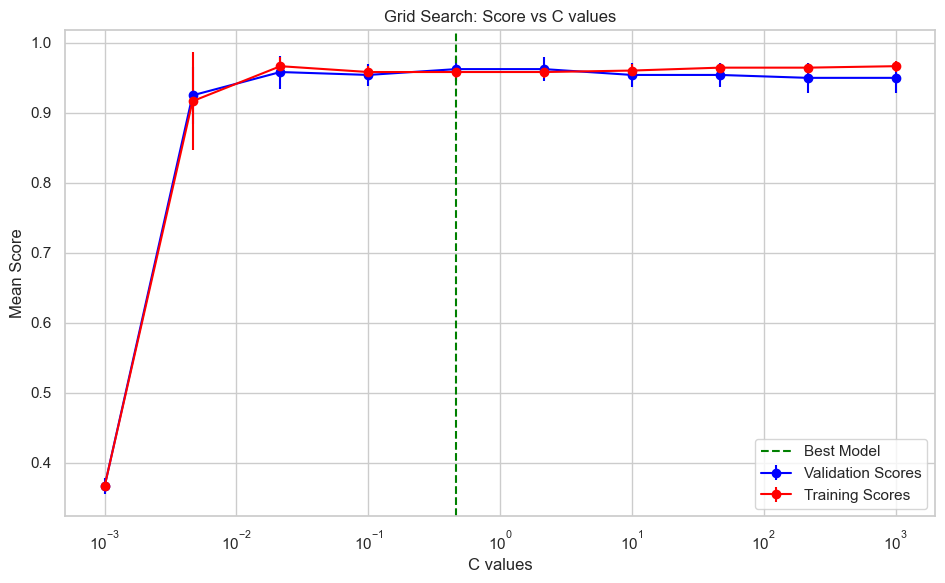

In [27]:
print(grid_outcomes.columns)
pipe_variable = 'param_model__C'
pipe_plot_name = 'C values'


plot_average_score_of_hyperparameters(grid_outcomes, pipe_variable, pipe_plot_name)

plt.xscale('log')

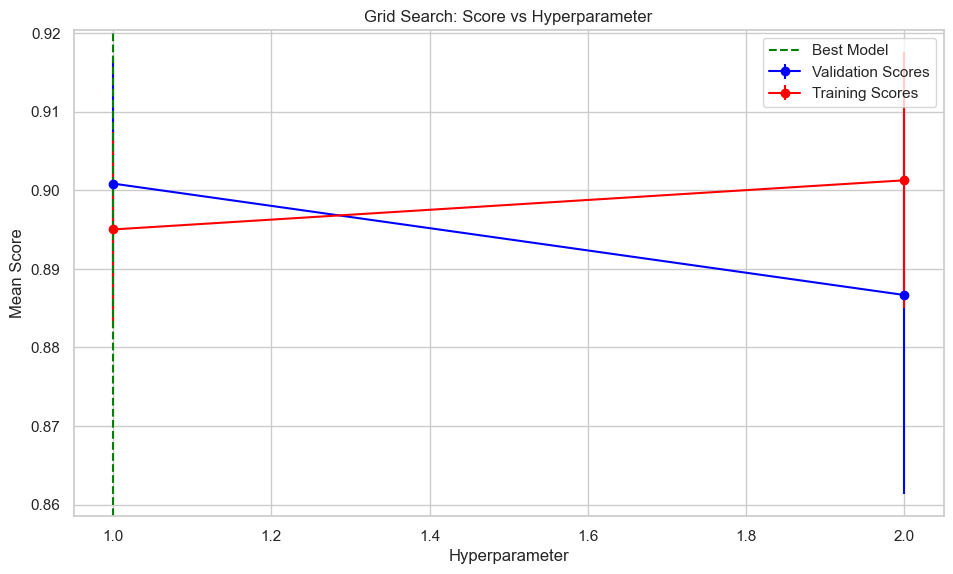

In [28]:
pipe_variable = 'param_dim_reducer__n_components'
pipe_plot_name = 'PCA Dimensions'

plot_average_score_of_hyperparameters(grid_outcomes, pipe_variable)

Accuracy: 0.9666666666666667
Precision: 0.9714285714285714
Recall (Sensitivity): 0.9666666666666667
F1 Score: 0.9671550671550672


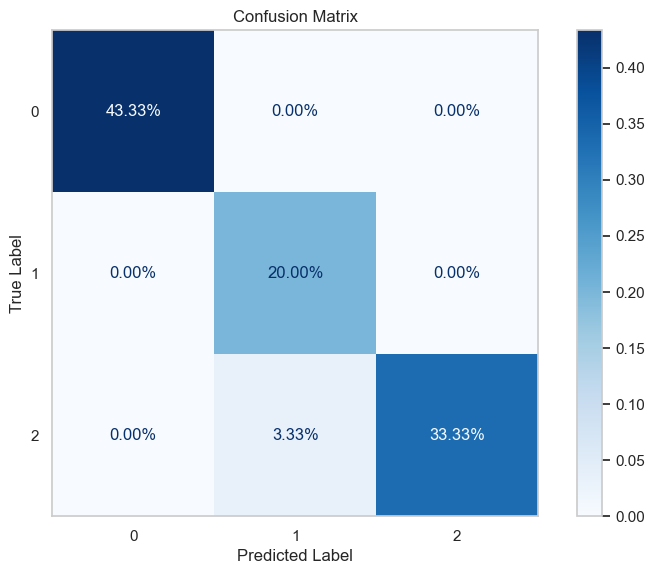

In [29]:

prediction_evaluations(best_model, X_test=X_test, y_test=y_test)

confusion_matrix_plot(best_model, X_test, y_test, [0, 1, 2])


The accuracy of this model is remarkably high, standing out as one of the best in my entire notebook! With an accuracy of 78%. it represents a significant improvement over the baseline accuracy of 57.61% and serves as an excellent starting point in the modeling process. However, the model does exhibit some difficulty in accurately predicting a good rating when the actual outcome is a bad rating, resulting in a false positive rate of 12.42%.

The specific use case for this model isn't entirely clear, but if I were to put myself in the shoes of a hotel owner, I would want a model that can accurately predict the likelihood of receiving a bad review. In this context, accuracy is a crucial metric, as it captures the model's ability to correctly predict both good and bad reviews. Moving forward, the focus should be on refining the model to improve its accuracy further and consequently reduce the false positive rate.  

## <a id='toc2_6_'></a>[Logistic Regression Model 1: Efficiency Evaluation](#toc0_)




Here I investigate the impact of Principal Component Analysis on the model's accuracy and runtime. I used many of the same processes as before to create a pipeline and gridsearchcv to search through several different hyperparameters of logistic regression with PCA. 

**F_classif**

The `f_classif` function in scikit-learn computes the F-value and p-value for feature scoring in classification tasks, providing insight into the relationship between each feature and the target variable. A higher F-value indicates a more informative feature, while a lower p-value suggests the feature is more likely to be relevant for the classification task. I used this feature selection method to select the top 50th percentile of most informative features for the PCA model.

In [30]:
grid_outcomes.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_dim_reducer', 'param_dim_reducer__n_components',
       'param_feature_selection', 'param_model', 'param_model__C',
       'param_model__penalty', 'param_scaler', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

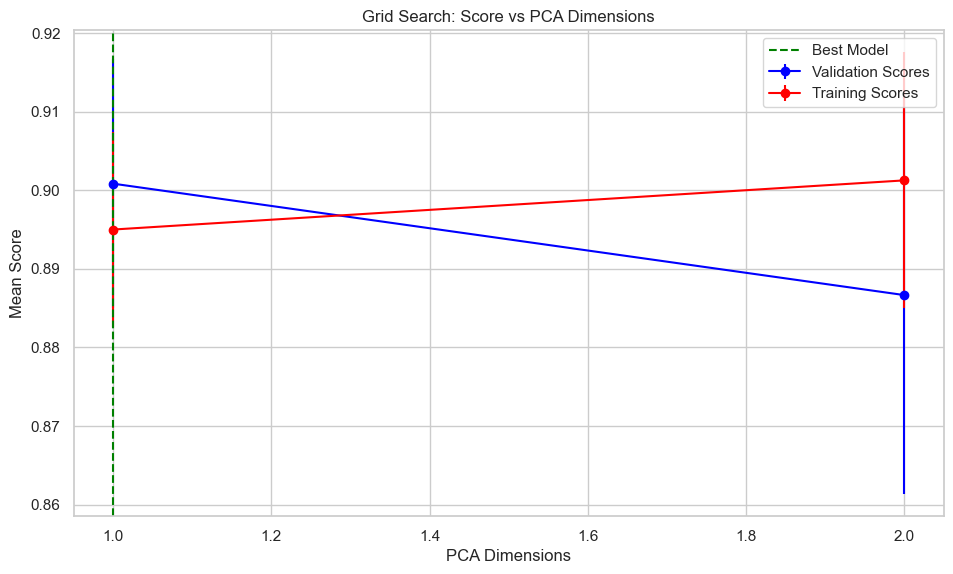

In [31]:
pipe_variable = 'param_dim_reducer__n_components'
pipe_plot_name = 'PCA Dimensions'

plot_average_score_of_hyperparameters(grid_outcomes, pipe_variable, pipe_plot_name)

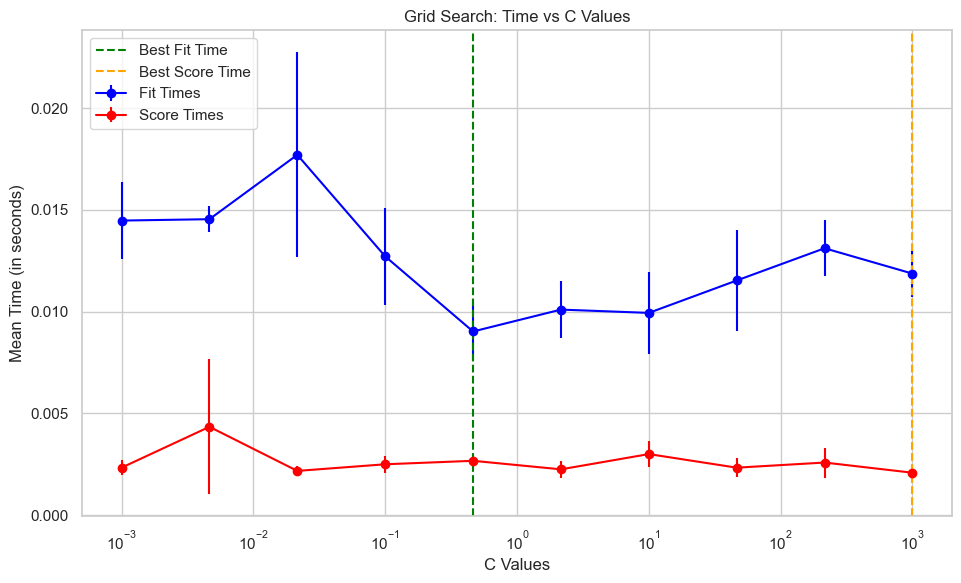

In [32]:
pipe_variable = 'param_model__C'
pipe_plot_name = 'C Values'

plot_average_time_of_hyperparameters(grid_outcomes, pipe_variable, pipe_plot_name)

plt.xscale('log')

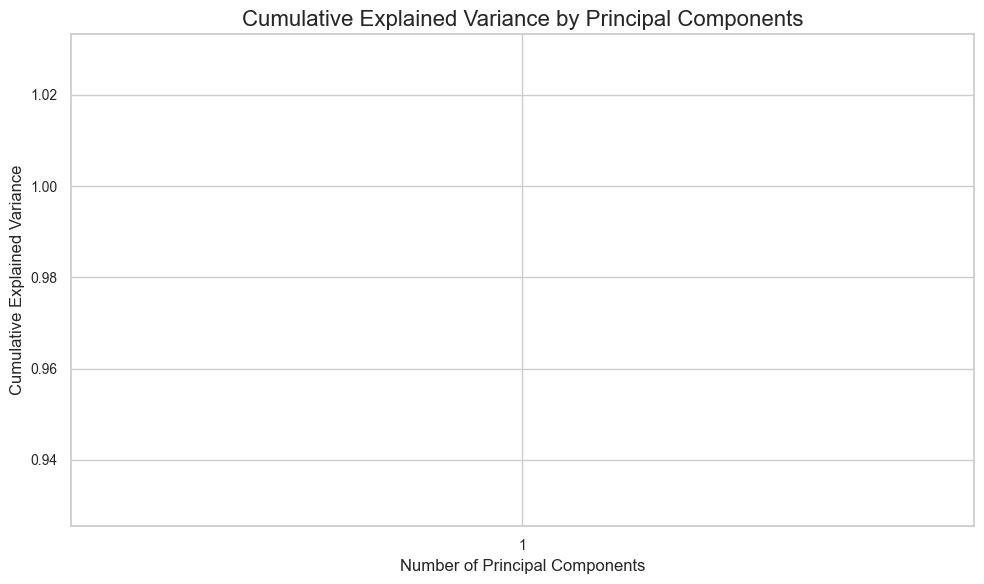

In [33]:
cum_sum_variance_explained = best_model.named_steps['dim_reducer'].explained_variance_ratio_.cumsum()
pca_component = range(1, len(cum_sum_variance_explained) + 1)

plt.figure(figsize=(10, 6))
sns.lineplot(x=pca_component, y=cum_sum_variance_explained, color='b', linewidth=2)

plt.title("Cumulative Explained Variance by Principal Components", fontsize=16)
plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative Explained Variance", fontsize=12)

plt.xticks(range(1, len(pca_component) + 1, 5), fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()



## <a id='toc2_7_'></a>[Logistic Regression: Assessing Residuals](#toc0_)


**Independence and Identically Distributed Test**

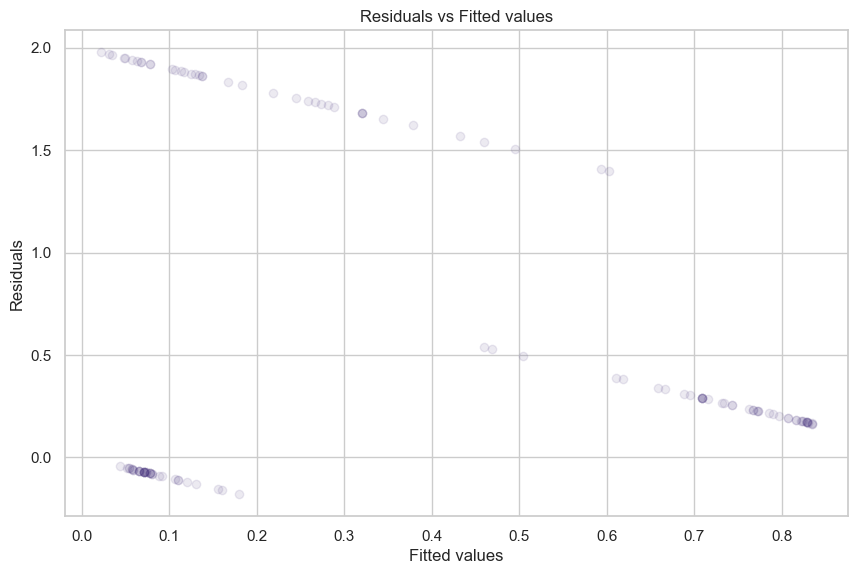

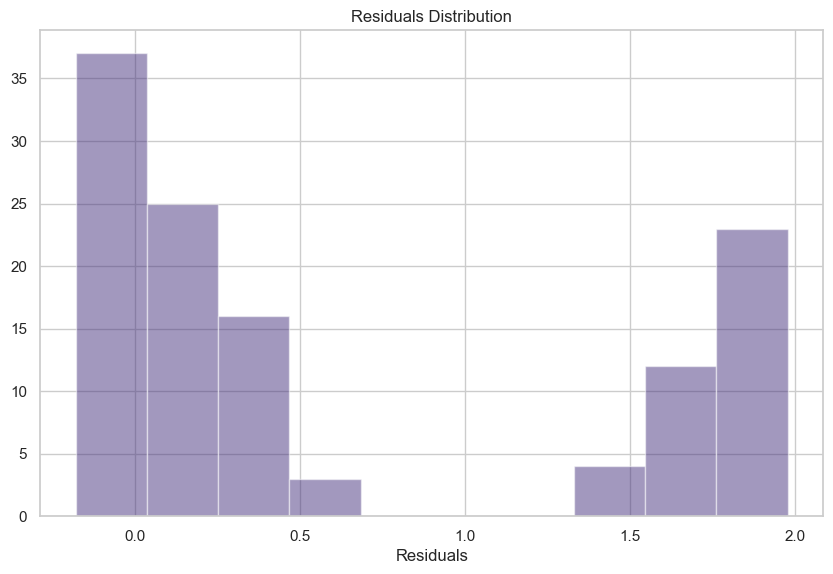

Durbin-Watson statistic: 1.1092794149489114


In [34]:
# Compute predicted probabilities
y_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Compute residuals
residuals = y_train - y_pred_proba

# Plot residuals
plt.scatter(y_pred_proba, residuals, alpha=0.1)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

# Plot residuals
plt.hist(residuals, alpha=0.5)
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()


# Perform Durbin-Watson test
dw = durbin_watson(residuals)
print('Durbin-Watson statistic:', dw)

These two visual tests show that the distribution of the residuals is normally distributed and appears to be independent of the fitted values. Furthermore, the Durbin-Watson of the residuals is close to 2, which indicates that there is very little to no autocorrelation in the residuals. Therefore we can conclude that the residuals are not correlated with each other and the distribution of the residuals is not dependent on the predicted probability of the target class. This means that this model meets the assumption of independence and identically distributed. 



# <a id='toc3_'></a>[Key Findings](#toc0_)

Summarize the findings from the analyses.



# <a id='toc4_'></a>[Recommendations](#toc0_)

List number of actionables based on the findings.